(This post has been edited after Philippe Lonjoux's insightful comment. The amendments I made are highlighted in my answer to his comment.)


Hello there!

This notebook exploits the analysis I did [here][1] to boost the performance of a classifier.

In particular, I will show how additional features computed from 'manager_id' can substantially improve performances by building upon the neat ["Random Forest Starter"][2] by Li Li

  [1]: https://www.kaggle.com/den3b81/two-sigma-connect-rental-listing-inquiries/do-managers-matter-some-insights-on-manager-id
  [2]: https://www.kaggle.com/aikinogard/two-sigma-connect-rental-listing-inquiries/random-forest-starter-with-numerical-features

In [7]:
# ...let's import the modules
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import log_loss

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# ... and load the training data
df = pd.read_json(open("../input/train.json", "r"))

### Naive feature engineering (from Li Li's Random Forest Starter)

In [3]:
df["num_photos"] = df["photos"].apply(len)
df["num_features"] = df["features"].apply(len)
df["num_description_words"] = df["description"].apply(lambda x: len(x.split(" ")))
df["created"] = pd.to_datetime(df["created"])
df["created_year"] = df["created"].dt.year
df["created_month"] = df["created"].dt.month
df["created_day"] = df["created"].dt.day

features_to_use = ["bathrooms", "bedrooms", "latitude", "longitude", "price",
                   "num_photos", "num_features", "num_description_words",
                   "created_year", "created_month", "created_day"]

### Basic encoding of 'manager_id', from SRK ["XGBoost starter"][1] 


  [1]: https://www.kaggle.com/sudalairajkumar/two-sigma-connect-rental-listing-inquiries/xgb-starter-in-python

In [4]:
from sklearn import preprocessing

lbl = preprocessing.LabelEncoder()
lbl.fit(list(df['manager_id'].values))
df['manager_id'] = lbl.transform(list(df['manager_id'].values))

# let's add this feature
features_to_use.append('manager_id')

### Let's now add 3 columns contaning the fractions of 'low','medium' and 'high' interest level obtained by each manager in the training dataset. 

### We also add the simple 'manager_skill' feature I introduced in my [previous notebook][1].

### We use mean values for those managers who don't have enough entries for being ranked (minimum = 20 here).


----------


### As pointed out by Philippe Lonjoux's, since these new features involve the target variable, we split the dataset first so to avoid "cheating" during the validation phase. The features are computed for each manager on the training part and the values obtained are then copied for the instances in the validation dataset. 


  [1]: https://www.kaggle.com/den3b81/two-sigma-connect-rental-listing-inquiries/do-managers-matter-some-insights-on-manager-id.

In [5]:
# Let's split the data
X = df[features_to_use]
y = df["interest_level"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33)

In [6]:
# compute fractions and count for each manager
temp = pd.concat([X_train.manager_id,pd.get_dummies(y_train)], axis = 1).groupby('manager_id').mean()
temp.columns = ['high_frac','low_frac', 'medium_frac']
temp['count'] = X_train.groupby('manager_id').count().iloc[:,1]

# remember the manager_ids look different because we encoded them in the previous step 
print(temp.tail(10))

            high_frac  low_frac  medium_frac  count
manager_id                                         
3471         0.000000  0.666667     0.333333      3
3472         0.666667  0.333333     0.000000      6
3473         0.000000  1.000000     0.000000      1
3474         0.000000  1.000000     0.000000      1
3475         0.000000  0.800000     0.200000      5
3476         0.000000  1.000000     0.000000      1
3477         0.000000  1.000000     0.000000      7
3478         0.000000  1.000000     0.000000      1
3479         0.200000  0.800000     0.000000      5
3480         0.025000  0.662500     0.312500     80


In [8]:
# compute skill
temp['manager_skill'] = temp['high_frac']*2 + temp['medium_frac']

# get ixes for unranked managers...
unranked_managers_ixes = temp['count']<20
# ... and ranked ones
ranked_managers_ixes = ~unranked_managers_ixes

# compute mean values from ranked managers and assign them to unranked ones
mean_values = temp.loc[ranked_managers_ixes, ['high_frac','low_frac', 'medium_frac','manager_skill']].mean()
print(mean_values)
temp.loc[unranked_managers_ixes,['high_frac','low_frac', 'medium_frac','manager_skill']] = mean_values.values
print(temp.tail(10))

high_frac        0.081138
low_frac         0.661574
medium_frac      0.257288
manager_skill    0.419564
dtype: float64
            high_frac  low_frac  medium_frac  count  manager_skill
manager_id                                                        
3471         0.081138  0.661574     0.257288      3       0.419564
3472         0.081138  0.661574     0.257288      6       0.419564
3473         0.081138  0.661574     0.257288      1       0.419564
3474         0.081138  0.661574     0.257288      1       0.419564
3475         0.081138  0.661574     0.257288      5       0.419564
3476         0.081138  0.661574     0.257288      1       0.419564
3477         0.081138  0.661574     0.257288      7       0.419564
3478         0.081138  0.661574     0.257288      1       0.419564
3479         0.081138  0.661574     0.257288      5       0.419564
3480         0.025000  0.662500     0.312500     80       0.362500


In [9]:
# inner join to assign manager features to the managers in the training dataframe
X_train = X_train.merge(temp.reset_index(),how='left', left_on='manager_id', right_on='manager_id')
X_train.head()

,bathrooms,bedrooms,latitude,longitude,price,num_photos,num_features,num_description_words,created_year,created_month,created_day,manager_id,high_frac,low_frac,medium_frac,count,manager_skill
0,2.0,2,40.7698,-73.9839,6195,1,4,104,2016,6,25,1952,0.081138,0.661574,0.257288,19,0.419564
1,1.0,1,40.7192,-73.9828,2560,4,2,102,2016,6,9,442,0.000000,0.807692,0.192308,26,0.192308
2,2.0,2,40.7316,-73.9871,4750,0,2,1,2016,6,21,2871,0.051852,0.829630,0.118519,135,0.222222
3,1.0,2,40.8458,-73.9428,2195,3,0,62,2016,6,17,348,0.084337,0.457831,0.457831,83,0.626506
4,2.0,5,40.7151,-74.0076,9500,4,2,40,2016,5,4,80,0.081138,0.661574,0.257288,17,0.419564


In [10]:
# add the features computed on the training dataset to the validation dataset
X_val = X_val.merge(temp.reset_index(),how='left', left_on='manager_id', right_on='manager_id')
new_manager_ixes = X_val['high_frac'].isnull()
X_val.loc[new_manager_ixes,['high_frac','low_frac', 'medium_frac','manager_skill']] = mean_values.values
X_val.head()

,bathrooms,bedrooms,latitude,longitude,price,num_photos,num_features,num_description_words,created_year,created_month,created_day,manager_id,high_frac,low_frac,medium_frac,count,manager_skill
0,1.0,2,40.8775,-73.8800,1695,4,2,26,2016,6,9,1356,0.081138,0.661574,0.257288,11.0,0.419564
1,2.0,4,40.7539,-73.9666,6200,5,6,89,2016,5,11,1411,0.101695,0.372881,0.525424,59.0,0.728814
2,1.0,1,40.7412,-73.9772,3050,3,5,123,2016,4,26,147,0.000000,0.821429,0.178571,28.0,0.178571
3,2.0,3,40.7436,-73.9727,4280,4,12,87,2016,5,9,1788,0.000000,0.915493,0.084507,142.0,0.084507
4,1.0,0,40.7344,-74.0056,2500,4,2,62,2016,5,13,225,0.084746,0.745763,0.169492,118.0,0.338983


In [13]:
# add manager fractions and skills to the features to use
features_to_use.extend(['high_frac','low_frac', 'medium_frac','manager_skill'])

### Let's train and validate a few random forest classifiers to see whether we can improve performances with thee additional features

### Basic model with no manager-related features, this is the model in Li Li's Random Forest Starter

In [16]:
# features to use for this classifier == only basic numerical
these_features = [f for f in features_to_use if f not in ['manager_id','high_frac','low_frac', 'medium_frac','manager_skill']]

clf = RandomForestClassifier(n_estimators=1000)
clf.fit(X_train[these_features], y_train)
y_val_pred = clf.predict_proba(X_val[these_features])
log_loss(y_val, y_val_pred)

0.6304616901027601

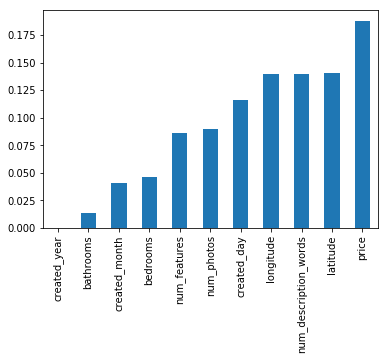

In [17]:
# Let's visualize features importance, 
# price is the most important feature, followed by number of descriptive words, latitude and longitude
pd.Series(index = these_features, data = clf.feature_importances_).sort_values().plot(kind = 'bar')

### Let's add manager_id and see if we can get some improvement already

In [18]:
# add manager_id
these_features = [f for f in features_to_use if f not in ['high_frac','low_frac', 'medium_frac','manager_skill']]

clf = RandomForestClassifier(n_estimators=1000)
clf.fit(X_train[these_features], y_train)
y_val_pred = clf.predict_proba(X_val[these_features])
log_loss(y_val, y_val_pred)

0.62590615880390965

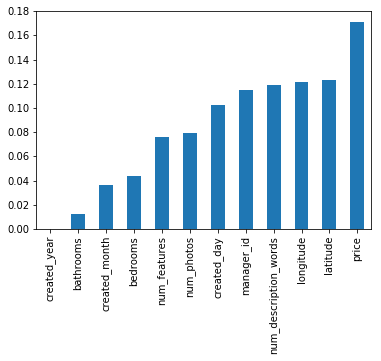

In [19]:
# Let's visualize features importance
pd.Series(index = these_features, data = clf.feature_importances_).sort_values().plot(kind = 'bar')

### We get a small improvement, but we can do better. Let's remove 'manager_id' and use manager interest fractions and skill instead

In [20]:
# no manager_id, use fractions and skill instad
these_features = [f for f in features_to_use if f not in ['manager_id']]

clf = RandomForestClassifier(n_estimators=1000)
clf.fit(X_train[these_features], y_train)
y_val_pred = clf.predict_proba(X_val[these_features])
log_loss(y_val, y_val_pred)

0.62193070306469

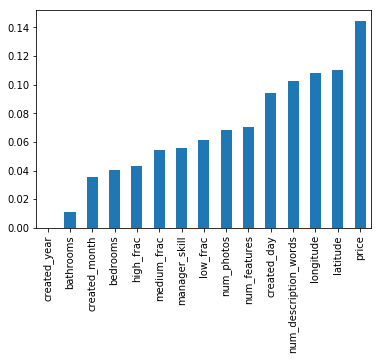

In [21]:
# Let's visualize features importance
pd.Series(index = these_features, data = clf.feature_importances_).sort_values().plot(kind = 'bar')

### That's an improvement, but maybe we can do better if we just use the fractions.

In [22]:
# no manager_id, no skill, use fractions
these_features = [f for f in features_to_use if f not in ['manager_id','manager_skill']]

clf = RandomForestClassifier(n_estimators=1000)
clf.fit(X_train[these_features], y_train)
y_val_pred = clf.predict_proba(X_val[these_features])
log_loss(y_val, y_val_pred)

0.61707297640694447

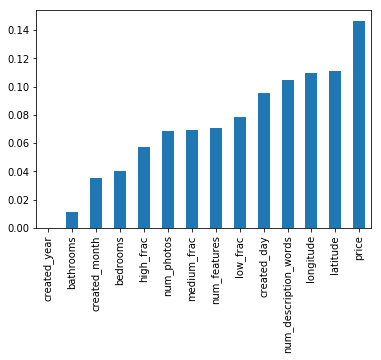

In [23]:
# Let's visualize features importance
pd.Series(index = these_features, data = clf.feature_importances_).sort_values().plot(kind = 'bar')

### What if we use the manager skill and not the fractions?!

In [24]:
# no manager_id, no fraction, use skill instead
these_features = [f for f in features_to_use if f not in ['manager_id','high_frac','low_frac', 'medium_frac']]

clf = RandomForestClassifier(n_estimators=1000)
clf.fit(X_train[these_features], y_train)
y_val_pred = clf.predict_proba(X_val[these_features])
log_loss(y_val, y_val_pred)

0.61267429668356044

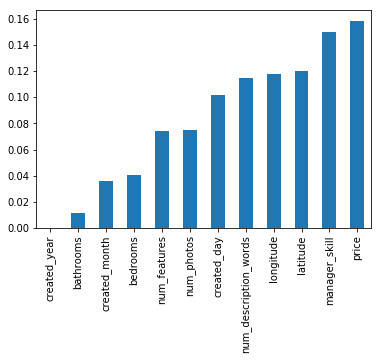

In [25]:
# Let's visualize features importance
pd.Series(index = these_features, data = clf.feature_importances_).sort_values().plot(kind = 'bar')

### Oh cool, manager_skill still does boost our performances further and it is almost as important as the price feature.

### Therefore, I suggest you to use this feature in your classifier, no matter its nature. I am confident you gonna get a nice boost if you are not including similar features already in your model.


### Cheers